In [ ]:
from transformers import AutoTokenizer, GPT2LMHeadModel, AutoConfig, DataCollatorForLanguageModeling, pipeline
import datasets
import torch
from transformers import Trainer, TrainingArguments
import matplotlib.pyplot as plt
from torchaudio.functional import edit_distance

In [2]:
data_files = {"train": "train.txt", "validation": "test.txt"}

users_dataset = datasets.load_dataset(r'data\raw_data\32k_30lvls',data_files=data_files)

Using custom data configuration 32k_30lvls-be7a1b5efbf1fe8c


Generating train split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Dataset text downloaded and prepared to C:/Users/Administrator/.cache/huggingface/datasets/text/32k_30lvls-be7a1b5efbf1fe8c/0.0.0/99cc88223027054f94ce0c7fd69d10eb172910fa0615671283a3c8e5e7af2f9c. Subsequent calls will reuse this data.


  0%|          | 0/2 [00:00<?, ?it/s]

In [3]:
users_dataset

DatasetDict({
    train: Dataset({
        features: ['text'],
        num_rows: 25808
    })
    validation: Dataset({
        features: ['text'],
        num_rows: 6453
    })
})

In [4]:
users_dataset['train']['text'][0]

'start win start win start win start win start win start win start win start win start win start win start win start boostHammer lose start win start boostSwapElements win start win start win start boostCross win start lose start lose start horn win start win start win start lose start amuletBomb win start win start lose start horn win start boostSwapElements lose start boostCross amuletMoves win start win start win start win start lose start amuletMoves win start lose start amuletBomb win start win start win start win start lose start amuletMoves win start win start win start boostCross boostCross win start win start lose start horn lose start boostHammer win start lose start horn lose start horn lose start win start lose start win churn start win start win start win start lose start lose start win start lose start lose start win start lose'

In [5]:
old_tokenizer = AutoTokenizer.from_pretrained('gpt2')

In [6]:
def get_training_corpus(dataset: datasets.Dataset):
    training_corpus = (dataset["train"][i]['text'] for i in range(len(dataset["train"])))
    return training_corpus


In [7]:
vocab_size = 5000

In [8]:
training_corpus = get_training_corpus(users_dataset)

In [9]:
tokenizer = old_tokenizer.train_new_from_iterator(text_iterator=training_corpus, vocab_size=vocab_size)

In [10]:
# tokenizer.add_special_tokens({'eos_token': 'churn'})

In [11]:
len(tokenizer)

337

In [12]:
tokenizer.tokenize('win start lose start lose start lose start win start boostHammer win start lose start amuletBomb win start lose ')

['win',
 'Ġstart',
 'Ġlose',
 'Ġstart',
 'Ġlose',
 'Ġstart',
 'Ġlose',
 'Ġstart',
 'Ġwin',
 'Ġstart',
 'ĠboostHammer',
 'Ġwin',
 'Ġstart',
 'Ġlose',
 'Ġstart',
 'ĠamuletBomb',
 'Ġwin',
 'Ġstart',
 'Ġlose',
 'Ġ']

In [13]:
tokenizer.bos_token_id

0

In [14]:
tokenizer.eos_token_id

0

In [15]:
context_len = 500

In [16]:
def map_tokenize(elem):
    outputs = tokenizer(elem['text'],
                        truncation=True,
                        # padding=True,
                        max_length=context_len,
                        return_overflowing_tokens=True,
                        return_length=True
                        )
    inp_batch = []

    for length, input_ids in zip(outputs["length"], outputs["input_ids"]):
        if length <= context_len:
            inp_batch.append(input_ids)

    return {'input_ids': inp_batch}

In [17]:
tokenized_dataset = users_dataset.map(map_tokenize, batched=True, remove_columns=users_dataset["train"].column_names)

  0%|          | 0/26 [00:00<?, ?ba/s]

  0%|          | 0/7 [00:00<?, ?ba/s]

In [18]:
config = AutoConfig.from_pretrained('gpt2',
                                    vocab_size=len(tokenizer),
                                    context_len=context_len,
                                    bos_token_id=tokenizer.bos_token_id,
                                    eos_token_id=tokenizer.eos_token_id
                                    )

In [19]:
config

GPT2Config {
  "_name_or_path": "gpt2",
  "activation_function": "gelu_new",
  "architectures": [
    "GPT2LMHeadModel"
  ],
  "attn_pdrop": 0.1,
  "bos_token_id": 0,
  "embd_pdrop": 0.1,
  "eos_token_id": 0,
  "initializer_range": 0.02,
  "layer_norm_epsilon": 1e-05,
  "model_type": "gpt2",
  "n_ctx": 1024,
  "n_embd": 768,
  "n_head": 12,
  "n_inner": null,
  "n_layer": 12,
  "n_positions": 1024,
  "reorder_and_upcast_attn": false,
  "resid_pdrop": 0.1,
  "scale_attn_by_inverse_layer_idx": false,
  "scale_attn_weights": true,
  "summary_activation": null,
  "summary_first_dropout": 0.1,
  "summary_proj_to_labels": true,
  "summary_type": "cls_index",
  "summary_use_proj": true,
  "task_specific_params": {
    "text-generation": {
      "do_sample": true,
      "max_length": 50
    }
  },
  "transformers_version": "4.24.0",
  "use_cache": true,
  "vocab_size": 337
}

In [20]:
model = GPT2LMHeadModel(config).to(torch.device('cuda'))

In [21]:
tokenizer.pad_token = tokenizer.eos_token
data_collator = DataCollatorForLanguageModeling(tokenizer, mlm=False)

In [23]:
batch_size = 16
args = TrainingArguments(
    output_dir="users_actions_train_50epochs_32k",
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    evaluation_strategy="steps",
    eval_steps=100,
    logging_steps=100,
    gradient_accumulation_steps=2,
    num_train_epochs=50,
    weight_decay=0.1,
    warmup_steps=1_000,
    lr_scheduler_type="cosine",
    learning_rate=5e-4,
    save_steps=5000,
    fp16=True,
    push_to_hub=False,
)

In [25]:
trainer = Trainer(
    model=model,
    tokenizer=tokenizer,
    args=args,
    data_collator=data_collator,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["validation"],
)

Using cuda_amp half precision backend


Train without special tokens setup

In [23]:
trainer.train()

c:\programdata\miniconda3\lib\site-packages\transformers\optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 7958
  Num Epochs = 40
  Instantaneous batch size per device = 12
  Total train batch size (w. parallel, distributed & accumulation) = 24
  Gradient Accumulation steps = 2
  Total optimization steps = 13280
  Number of trainable parameters = 86102784


Step,Training Loss,Validation Loss
100,0.614400,0.624296
200,0.609600,0.630842
300,0.605700,0.635433
400,0.609100,0.634551
500,0.610200,0.653320
600,0.613200,0.645863
700,0.610100,0.645474
800,0.609600,0.643130
900,0.605200,0.639273
1000,0.606400,0.634433


***** Running Evaluation *****
  Num examples = 1994
  Batch size = 12
***** Running Evaluation *****
  Num examples = 1994
  Batch size = 12
Saving model checkpoint to users_actions_train\checkpoint-250
Configuration saved in users_actions_train\checkpoint-250\config.json
Model weights saved in users_actions_train\checkpoint-250\pytorch_model.bin
tokenizer config file saved in users_actions_train\checkpoint-250\tokenizer_config.json
Special tokens file saved in users_actions_train\checkpoint-250\special_tokens_map.json
***** Running Evaluation *****
  Num examples = 1994
  Batch size = 12
***** Running Evaluation *****
  Num examples = 1994
  Batch size = 12
***** Running Evaluation *****
  Num examples = 1994
  Batch size = 12
Saving model checkpoint to users_actions_train\checkpoint-500
Configuration saved in users_actions_train\checkpoint-500\config.json
Model weights saved in users_actions_train\checkpoint-500\pytorch_model.bin
tokenizer config file saved in users_actions_train\ch

TrainOutput(global_step=13280, training_loss=0.5297425666487361, metrics={'train_runtime': 9056.8501, 'train_samples_per_second': 35.147, 'train_steps_per_second': 1.466, 'total_flos': 7.9925712291072e+16, 'train_loss': 0.5297425666487361, 'epoch': 40.0})

Train with eos = 'stop'

In [56]:
trainer.train()

c:\programdata\miniconda3\lib\site-packages\transformers\optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 7958
  Num Epochs = 5
  Instantaneous batch size per device = 12
  Total train batch size (w. parallel, distributed & accumulation) = 24
  Gradient Accumulation steps = 2
  Total optimization steps = 1660
  Number of trainable parameters = 86103552
You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Step,Training Loss,Validation Loss
100,1.197500,0.663507
200,0.674500,0.653966
300,0.652900,0.643910
400,0.644600,0.643954
500,0.641600,0.644555
600,0.633000,0.655182
700,0.630000,0.648660
800,0.628800,0.641957
900,0.623000,0.635541
1000,0.616300,0.623787


***** Running Evaluation *****
  Num examples = 1994
  Batch size = 12
***** Running Evaluation *****
  Num examples = 1994
  Batch size = 12
Saving model checkpoint to users_actions_train_eos_stop\checkpoint-250
Configuration saved in users_actions_train_eos_stop\checkpoint-250\config.json
Model weights saved in users_actions_train_eos_stop\checkpoint-250\pytorch_model.bin
tokenizer config file saved in users_actions_train_eos_stop\checkpoint-250\tokenizer_config.json
Special tokens file saved in users_actions_train_eos_stop\checkpoint-250\special_tokens_map.json
***** Running Evaluation *****
  Num examples = 1994
  Batch size = 12
***** Running Evaluation *****
  Num examples = 1994
  Batch size = 12
***** Running Evaluation *****
  Num examples = 1994
  Batch size = 12
Saving model checkpoint to users_actions_train_eos_stop\checkpoint-500
Configuration saved in users_actions_train_eos_stop\checkpoint-500\config.json
Model weights saved in users_actions_train_eos_stop\checkpoint-500

TrainOutput(global_step=1660, training_loss=0.6553705445255141, metrics={'train_runtime': 1125.4372, 'train_samples_per_second': 35.355, 'train_steps_per_second': 1.475, 'total_flos': 9992148208128000.0, 'train_loss': 0.6553705445255141, 'epoch': 5.0})

train with eos = 'churn'

In [89]:
trainer.train()

c:\programdata\miniconda3\lib\site-packages\transformers\optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 7961
  Num Epochs = 5
  Instantaneous batch size per device = 12
  Total train batch size (w. parallel, distributed & accumulation) = 24
  Gradient Accumulation steps = 2
  Total optimization steps = 1660
  Number of trainable parameters = 86103552
You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Step,Training Loss,Validation Loss
100,1.156000,0.691632
200,0.681200,0.667808
300,0.657500,0.650136
400,0.641300,0.635112
500,0.636100,0.639528
600,0.635000,0.643936
700,0.635200,0.628918
800,0.623400,0.628565
900,0.616400,0.643971
1000,0.617700,0.629692


***** Running Evaluation *****
  Num examples = 1994
  Batch size = 12
***** Running Evaluation *****
  Num examples = 1994
  Batch size = 12
Saving model checkpoint to users_actions_train_eos_churn\checkpoint-250
Configuration saved in users_actions_train_eos_churn\checkpoint-250\config.json
Model weights saved in users_actions_train_eos_churn\checkpoint-250\pytorch_model.bin
tokenizer config file saved in users_actions_train_eos_churn\checkpoint-250\tokenizer_config.json
Special tokens file saved in users_actions_train_eos_churn\checkpoint-250\special_tokens_map.json
***** Running Evaluation *****
  Num examples = 1994
  Batch size = 12
***** Running Evaluation *****
  Num examples = 1994
  Batch size = 12
***** Running Evaluation *****
  Num examples = 1994
  Batch size = 12
Saving model checkpoint to users_actions_train_eos_churn\checkpoint-500
Configuration saved in users_actions_train_eos_churn\checkpoint-500\config.json
Model weights saved in users_actions_train_eos_churn\checkp

TrainOutput(global_step=1660, training_loss=0.6530511396477021, metrics={'train_runtime': 1107.0853, 'train_samples_per_second': 35.955, 'train_steps_per_second': 1.499, 'total_flos': 1.0001062757376e+16, 'train_loss': 0.6530511396477021, 'epoch': 5.0})

train on dataset with drop stop token eos='churn'

In [37]:
trainer.train()

c:\programdata\miniconda3\lib\site-packages\transformers\optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 7961
  Num Epochs = 5
  Instantaneous batch size per device = 12
  Total train batch size (w. parallel, distributed & accumulation) = 24
  Gradient Accumulation steps = 2
  Total optimization steps = 1660
  Number of trainable parameters = 86102016
You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Step,Training Loss,Validation Loss
100,1.196100,0.669220
200,0.674300,0.661995
300,0.652400,0.645235
400,0.632900,0.630432
500,0.630300,0.630111
600,0.628100,0.634320
700,0.631000,0.633449
800,0.617900,0.624978
900,0.610900,0.631491
1000,0.610300,0.626185


***** Running Evaluation *****
  Num examples = 1994
  Batch size = 12
***** Running Evaluation *****
  Num examples = 1994
  Batch size = 12
Saving model checkpoint to users_actions_train_eos_churn_ds_drop_stop\checkpoint-250
Configuration saved in users_actions_train_eos_churn_ds_drop_stop\checkpoint-250\config.json
Model weights saved in users_actions_train_eos_churn_ds_drop_stop\checkpoint-250\pytorch_model.bin
tokenizer config file saved in users_actions_train_eos_churn_ds_drop_stop\checkpoint-250\tokenizer_config.json
Special tokens file saved in users_actions_train_eos_churn_ds_drop_stop\checkpoint-250\special_tokens_map.json
***** Running Evaluation *****
  Num examples = 1994
  Batch size = 12
***** Running Evaluation *****
  Num examples = 1994
  Batch size = 12
***** Running Evaluation *****
  Num examples = 1994
  Batch size = 12
Saving model checkpoint to users_actions_train_eos_churn_ds_drop_stop\checkpoint-500
Configuration saved in users_actions_train_eos_churn_ds_drop_

TrainOutput(global_step=1660, training_loss=0.6495612615562347, metrics={'train_runtime': 1113.5504, 'train_samples_per_second': 35.746, 'train_steps_per_second': 1.491, 'total_flos': 9998345728512000.0, 'train_loss': 0.6495612615562347, 'epoch': 5.0})

train same but pad=true

In [68]:
trainer.train()

c:\programdata\miniconda3\lib\site-packages\transformers\optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 7961
  Num Epochs = 5
  Instantaneous batch size per device = 12
  Total train batch size (w. parallel, distributed & accumulation) = 24
  Gradient Accumulation steps = 2
  Total optimization steps = 1660
  Number of trainable parameters = 86102016


Step,Training Loss,Validation Loss
100,1.217300,0.665639
200,0.668800,0.656647
300,0.653400,0.640830
400,0.632200,0.628457
500,0.632000,0.628739
600,0.626800,0.641891
700,0.627600,0.629329
800,0.619100,0.622826
900,0.610300,0.631213
1000,0.609000,0.623891


***** Running Evaluation *****
  Num examples = 1994
  Batch size = 12
***** Running Evaluation *****
  Num examples = 1994
  Batch size = 12
Saving model checkpoint to users_actions_train_eos_churn_ds_drop_stop\checkpoint-250
Configuration saved in users_actions_train_eos_churn_ds_drop_stop\checkpoint-250\config.json
Model weights saved in users_actions_train_eos_churn_ds_drop_stop\checkpoint-250\pytorch_model.bin
tokenizer config file saved in users_actions_train_eos_churn_ds_drop_stop\checkpoint-250\tokenizer_config.json
Special tokens file saved in users_actions_train_eos_churn_ds_drop_stop\checkpoint-250\special_tokens_map.json
***** Running Evaluation *****
  Num examples = 1994
  Batch size = 12
***** Running Evaluation *****
  Num examples = 1994
  Batch size = 12
***** Running Evaluation *****
  Num examples = 1994
  Batch size = 12
Saving model checkpoint to users_actions_train_eos_churn_ds_drop_stop\checkpoint-500
Configuration saved in users_actions_train_eos_churn_ds_drop_

TrainOutput(global_step=1660, training_loss=0.6498946040509695, metrics={'train_runtime': 921.7894, 'train_samples_per_second': 43.182, 'train_steps_per_second': 1.801, 'total_flos': 1.015696224e+16, 'train_loss': 0.6498946040509695, 'epoch': 5.0})

Current train 

In [ ]:
trainer.train()

c:\programdata\miniconda3\lib\site-packages\transformers\optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 28358
  Num Epochs = 50
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 32
  Gradient Accumulation steps = 2
  Total optimization steps = 44300
  Number of trainable parameters = 86101248
You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Step,Training Loss,Validation Loss
100,1.183700,0.690431
200,0.683200,0.657431
300,0.661600,0.647058
400,0.658100,0.636626
500,0.649300,0.630813
600,0.641000,0.619828
700,0.638200,0.618182
800,0.634300,0.627534
900,0.630500,0.616113
1000,0.624700,0.611292


***** Running Evaluation *****
  Num examples = 7084
  Batch size = 16
***** Running Evaluation *****
  Num examples = 7084
  Batch size = 16
***** Running Evaluation *****
  Num examples = 7084
  Batch size = 16
***** Running Evaluation *****
  Num examples = 7084
  Batch size = 16
***** Running Evaluation *****
  Num examples = 7084
  Batch size = 16
***** Running Evaluation *****
  Num examples = 7084
  Batch size = 16
***** Running Evaluation *****
  Num examples = 7084
  Batch size = 16
***** Running Evaluation *****
  Num examples = 7084
  Batch size = 16
***** Running Evaluation *****
  Num examples = 7084
  Batch size = 16
***** Running Evaluation *****
  Num examples = 7084
  Batch size = 16
***** Running Evaluation *****
  Num examples = 7084
  Batch size = 16
***** Running Evaluation *****
  Num examples = 7084
  Batch size = 16
***** Running Evaluation *****
  Num examples = 7084
  Batch size = 16
***** Running Evaluation *****
  Num examples = 7084
  Batch size = 16
***** 

DIRECT SAVING

In [25]:
trainer.save_model('gpt2_100epochs_pure_dataset')

Saving model checkpoint to gpt2_100epochs_pure_dataset
Configuration saved in gpt2_100epochs_pure_dataset\config.json
Model weights saved in gpt2_100epochs_pure_dataset\pytorch_model.bin
tokenizer config file saved in gpt2_100epochs_pure_dataset\tokenizer_config.json
Special tokens file saved in gpt2_100epochs_pure_dataset\special_tokens_map.json


In [26]:
tokenizer.save_pretrained("tokenizer_gpt2_100epochs_pure_dataset")

tokenizer config file saved in tokenizer_gpt2_100epochs_pure_dataset\tokenizer_config.json
Special tokens file saved in tokenizer_gpt2_100epochs_pure_dataset\special_tokens_map.json


('tokenizer_gpt2_100epochs_pure_dataset\\tokenizer_config.json',
 'tokenizer_gpt2_100epochs_pure_dataset\\special_tokens_map.json',
 'tokenizer_gpt2_100epochs_pure_dataset\\vocab.json',
 'tokenizer_gpt2_100epochs_pure_dataset\\merges.txt',
 'tokenizer_gpt2_100epochs_pure_dataset\\added_tokens.json',
 'tokenizer_gpt2_100epochs_pure_dataset\\tokenizer.json')

INFERENCE

In [73]:
generator = pipeline('text-generation',model=model.to(torch.device('cpu')),tokenizer=tokenizer)

In [74]:
sample = users_dataset['train']['text'][0]

In [75]:
sample = ' '.join(sample.split(' ')[:105])

In [76]:
sample

'win start win start win start win start win start win start win start lose start boostHammer win start win start win start boostHammer win start win start amuletMoves boostSwapElements win start win start win start lose start win start horn win start boostCross win start win start win start win start amuletBomb win start win start win start win start win start win start win start lose start lose start win start lose start win start win start win start win start win start lose start lose start win start boostHammer win start win start win start win start win start win start win'

In [79]:
out = generator(sample, max_length=600, num_return_sequences=5,)

Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.


In [80]:
out

[{'generated_text': 'win start win start win start win start win start win start win start lose start boostHammer win start win start win start boostHammer win start win start amuletMoves boostSwapElements win start win start win start lose start win start horn win start boostCross win start win start win start win start amuletBomb win start win start win start win start win start win start win start lose start lose start win start lose start win start win start win start win start win start lose start lose start win start boostHammer win start win start win start win start win start win start win start win start lose start lose start boostHammer win start lose start amuletBomb horn amuletBomb amuletMoves amuletMoves amuletBomb amuletBomb boostCross amuletMoves horn lose start win start win start win start win start lose start lose start horn lose start lose start horn lose start horn lose start win start win start win start lose start lose start lose start lose start win start lose st

In [33]:
encoded_input = tokenizer(sample, return_tensors='pt')


In [34]:
sample

'win start win start win start win start win start win start win start lose start boostHammer win start win start win start boostHammer win start win start amuletMoves boostSwapElements win start win start win start lose start win start horn win start boostCross win start win start win start win start amuletBomb win start win start win start win start win start win start win start lose start lose start win start lose start win start win start win start win start win start lose start lose start win start boostHammer win start win start win start win start win start win start win'

In [35]:
encoded_input

{'input_ids': tensor([[267, 261, 268, 261, 268, 261, 268, 261, 268, 261, 268, 261, 268, 261,
         265, 261, 291, 268, 261, 268, 261, 268, 261, 291, 268, 261, 268, 261,
         321, 320, 268, 261, 268, 261, 268, 261, 265, 261, 268, 261, 287, 268,
         261, 295, 268, 261, 268, 261, 268, 261, 268, 261, 310, 268, 261, 268,
         261, 268, 261, 268, 261, 268, 261, 268, 261, 268, 261, 265, 261, 265,
         261, 268, 261, 265, 261, 268, 261, 268, 261, 268, 261, 268, 261, 268,
         261, 265, 261, 265, 261, 268, 261, 291, 268, 261, 268, 261, 268, 261,
         268, 261, 268, 261, 268, 261, 268]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1]])}

In [36]:
input_ids = encoded_input['input_ids']

In [39]:
outputs = model.to(torch.device('cpu')).generate(input_ids, do_sample=True, max_length=500)
tokenizer.batch_decode(outputs, skip_special_tokens=False)

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:337 for open-end generation.


['win start win start win start win start win start win start win start lose start boostHammer win start win start win start boostHammer win start win start amuletMoves boostSwapElements win start win start win start lose start win start horn win start boostCross win start win start win start win start amuletBomb win start win start win start win start win start win start win start lose start lose start win start lose start win start win start win start win start win start lose start lose start win start boostHammer win start win start win start win start win start win start win start win start win start win start win start win start win start win start win start lose start win start win start boostHammer win start lose start win start lose start lose start lose start horn win start lose start win start lose start lose start lose start lose start win start win start win start win start lose start win start win start lose start lose start lose start lose start win start win start boostC

In [89]:
output = model.to(torch.device('cpu'))(**encoded_input)

In [90]:
output

CausalLMOutputWithCrossAttentions(loss=None, logits=tensor([[[-2.6974, -2.5569, -2.9424,  ..., -2.4379, -4.0071, -1.5883],
         [-4.6802, -4.7087, -4.0595,  ..., -4.3092, -6.5722, -1.0481],
         [-2.4545, -2.3605, -2.4015,  ..., -1.9664, -3.6429, -1.9394],
         ...,
         [-3.7891, -3.4489, -3.4743,  ..., -3.2357, -2.3698, -3.7398],
         [-7.2968, -7.0379, -6.7827,  ..., -7.1585, -3.4145, -5.0097],
         [-3.7887, -3.5834, -3.4531,  ..., -3.1636, -2.1059, -3.6968]]],
       grad_fn=<UnsafeViewBackward0>), past_key_values=((tensor([[[[ 8.6433e-01,  2.4671e-01, -1.1819e-01,  ...,  1.5776e-01,
           -8.5839e-01, -8.2961e-01],
          [ 6.9092e-01,  4.8118e-01, -3.1806e+00,  ...,  6.1375e-01,
           -3.3201e-01,  9.0175e-01],
          [ 1.0048e+00, -8.7370e-02, -4.2934e-02,  ..., -3.6135e-01,
            4.3767e-01,  6.6455e-01],
          ...,
          [ 1.1815e+00, -1.7211e+00,  1.6549e+00,  ..., -9.7626e-01,
            2.1689e-01,  6.1644e-01],
      

Test model inference on train

In [34]:
model.to(torch.device('cpu'))

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(337, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0): GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
      (1): GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropo

In [35]:
generator = pipeline('text-generation',model=model,tokenizer=tokenizer)

In [32]:
users_dataset['train']

Dataset({
    features: ['text'],
    num_rows: 7958
})

In [105]:
sample = users_dataset['train'][100]['text']

In [106]:
len(sample.split(' '))

396

In [107]:
sample_clip_105 = ' '.join(sample.split(' ')[:105])

In [108]:
sample

'win start win start win start win start win start win start win start boostHammer lose start boostHammer win start win start lose start lose start win start lose start lose start win start lose start win start amuletMoves win start amuletMoves win start win start win start horn amuletMoves win start horn amuletMoves win start horn amuletMoves win start amuletMoves horn win start lose start lose start win start amuletBomb win start win start win start lose start amuletBomb win start lose start amuletBomb lose start win start lose start lose start win start lose start lose start win start boostHammer boostHammer win start win start win start win start amuletMoves win start amuletMoves win start horn win start lose start lose start win start win start lose start win start win start win start win start win start lose start additionalMoves additionalMoves win start win start win start win start win start win start lose start additionalMoves additionalMoves lose start lose start lose start 

In [109]:
out = generator(sample_clip_105, max_length=500, num_return_sequences=1,)

Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.


In [110]:
out = out[0]['generated_text']

In [111]:
out = out.partition('churn')[0] + out.partition('churn')[1]

In [112]:
len(out.split(' '))

396

In [113]:
sample

'win start win start win start win start win start win start win start boostHammer lose start boostHammer win start win start lose start lose start win start lose start lose start win start lose start win start amuletMoves win start amuletMoves win start win start win start horn amuletMoves win start horn amuletMoves win start horn amuletMoves win start amuletMoves horn win start lose start lose start win start amuletBomb win start win start win start lose start amuletBomb win start lose start amuletBomb lose start win start lose start lose start win start lose start lose start win start boostHammer boostHammer win start win start win start win start amuletMoves win start amuletMoves win start horn win start lose start lose start win start win start lose start win start win start win start win start win start lose start additionalMoves additionalMoves win start win start win start win start win start win start lose start additionalMoves additionalMoves lose start lose start lose start 

In [114]:
out

'win start win start win start win start win start win start win start boostHammer lose start boostHammer win start win start lose start lose start win start lose start lose start win start lose start win start amuletMoves win start amuletMoves win start win start win start horn amuletMoves win start horn amuletMoves win start horn amuletMoves win start amuletMoves horn win start lose start lose start win start amuletBomb win start win start win start lose start amuletBomb win start lose start amuletBomb lose start win start lose start lose start win start lose start lose start win start boostHammer boostHammer win start win start win start win start amuletMoves win start amuletMoves win start horn win start lose start lose start win start win start lose start win start win start win start win start win start lose start additionalMoves additionalMoves win start win start win start win start win start win start lose start additionalMoves additionalMoves lose start lose start lose start 

In [115]:
sample_ids = tokenizer(sample)['input_ids']
out_ids = tokenizer(out)['input_ids']

In [116]:
edit_distance(sample_ids,out_ids) / len(out.split(' '))

0.0

edit distance

In [128]:
def samples_edit_distance(dataset, generator,first_n=105,counts=None):
    
    dists = []
    idxs = []
    skipped_short = []
    skipped_errors = []
    for i,sample in enumerate(dataset):
        sample = sample['text']
        sample_clip  = ' '.join(sample.split(' ')[:first_n])
        
        if len(sample_clip) <= first_n:
            skipped_short.append(i)
            continue
        try:
            out = generator(sample_clip, max_length=500, num_return_sequences=1,)
            out = out[0]['generated_text']
            out = out.partition('churn')[0] + out.partition('churn')[1]

            sample_ids_clip = tokenizer(sample)['input_ids'][first_n:]
            out_ids_clip = tokenizer(out)['input_ids'][first_n:]

            dist = edit_distance(sample_ids_clip,out_ids_clip) / len(out_ids_clip)
            dists.append(dist)
            idxs.append(i)
        except:
            skipped_errors.append(i)
        if counts:
            if i+1 == counts:
                break
    
    return dists,idxs,skipped_short,skipped_errors

In [134]:

dists,idxs,skipped_short,skipped_errors = samples_edit_distance(users_dataset['train'],generator)

Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:0 for o

In [135]:
import pickle

In [138]:
with open('dists_gpt2_100.pkl','wb') as f:
    pickle.dump(dists,f)
with open('idxs_gpt2_100.pkl','wb') as f:
    pickle.dump(idxs,f)
with open('skipped_short_100.pkl','wb') as f:
    pickle.dump(skipped_short,f)
with open('skipped_errors_gpt2_100.pkl','wb') as f:
    pickle.dump(skipped_errors,f)

In [140]:
skipped_short

[]

In [145]:
for d in dists:
    if d > 1: print(d)

3.7468354430379747
6.019230769230769
3.247311827956989
1.297872340425532
97.5
4.428571428571429
1.52
4.397260273972603
4.538461538461538
1.9576271186440677
1.407079646017699
2.5495495495495497
1.360759493670886
1.3703703703703705
18.7
1.3737373737373737
1.8759124087591241
1.4024390243902438
1.4893617021276595
1.1428571428571428
1.5
1.855263157894737
3.746987951807229
7.048780487804878
31.833333333333332


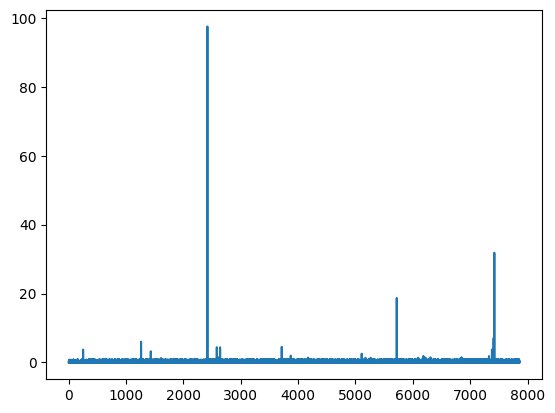

In [143]:
plt.plot(dists)